# Associate spindle/ripples and Ca2+ signal

In [1]:
cd "C:/Users/Manip2/SCRIPTS/Code python audrey/code python aurelie/interfaceJupyter/minian"

C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian


In [2]:
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import xarray as xr
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer

from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

Load sleep score and Ca2+ time series numpy arrays

In [6]:
folder_base = Path('//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording/BlackLinesOK/session1')

folder_Ephys = folder_base / f'OpenEphys/'
folder_Minis = folder_base / f'V4_Miniscope/minian/'

filenameE = folder_Ephys / f'SWRproperties.csv'
SWRprop = pd.read_csv(filenameE)
filenameE = folder_Ephys / f'Spindleproperties_PFC.csv'
PFCspiprop = pd.read_csv(filenameE)
filenameE = folder_Ephys / f'Spindleproperties_S1.csv'
S1spiprop = pd.read_csv(filenameE)
filenameB = folder_base / f'SynchroFile.xlsx'
stamps = pd.read_excel(filenameB)
#filenameU = folder_Minis / f'UniTtoKeepAB.xlsx'
#UnitToKeep = pd.read_excel(filenameU)
#UnitToKeepL = UnitToKeep[0].to_list()
minian_ds = open_minian(folder_Minis)


for file_path in folder_base.glob('**/timeStamps.csv'):
    subfolder = file_path.parents[0].stem
    if subfolder == 'V4_Miniscope':
        stamps_miniscope = pd.read_csv(file_path)

Acq_freq = (list(stamps[0])[2])

TodropFile = folder_Minis / f'TodropFileAB.json'
with open(TodropFile, 'r') as f:
    unit_to_drop = json.load(f)
TodropFile = folder_Minis / f'AllunitsFileAB.json'
with open(TodropFile, 'r') as f:
    All_units = json.load(f)

#UnitToKeepInd = [e for e, elem in enumerate(All_units) if elem in UnitToKeepL]
#UnitToKeepInd

C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

In [7]:
All_units

[0, 3, 9, 10, 12, 14, 16]

Adjust start time on ephys and remove unit to drop on Minian

In [8]:
S1spiprop[["peak time", "start time", "end time"]] = S1spiprop[["peak time", "start time", "end time"]]-(list(stamps[0])[0]*1000)
PFCspiprop[["peak time", "start time", "end time"]] = PFCspiprop[["peak time", "start time", "end time"]]-(list(stamps[0])[0]*1000)
SWRprop[["peak time", "start time", "end time"]] = SWRprop[["peak time", "start time", "end time"]]-(list(stamps[0])[0]*1000)
C = minian_ds['S']
A = minian_ds['A']
B = A['unit_id']
A = minian_ds['A']
B = A['unit_id']
copyB = list(B.copy())
for i in range(len(unit_to_drop)):
    elem = unit_to_drop[i]
    copyB.remove(elem)
unit_to_keep = copyB

C = C.loc[unit_to_keep,:]
nb_unit = C.shape[0]
rec_dur = C.shape[1]
print(nb_unit)

6


In [9]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

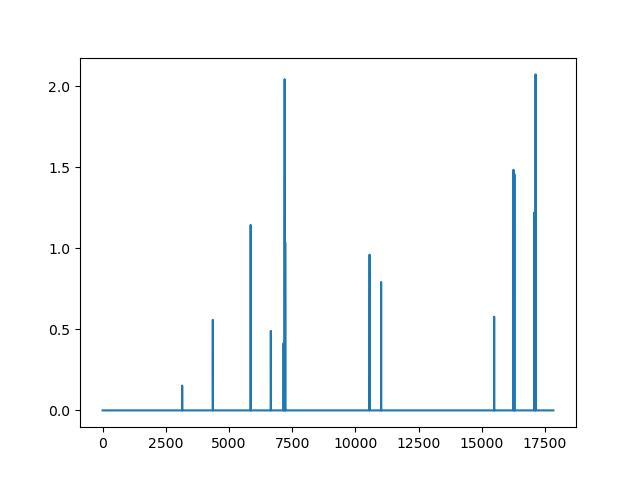

In [11]:
Cseries = C.to_series()
unit = 0
lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
lCseries
time = range(rec_dur)
plt.close()
plt.plot(time, lCseries)
plt.show()

Option 1: For each cell, avg activity 3s around the onset of spindles

0
1
2
3
4
5
6
502
503
504
505
0
1
2
3
4
5
6
502
503
504
505
0
1
2
3
4
5
6
502
503
504
505
0
1
2
3
4
5
6
502
503
504
505
0
1
2
3
4
5
6
502
503
504
505
0
1
2
3
4
5
6
502
503
504
505


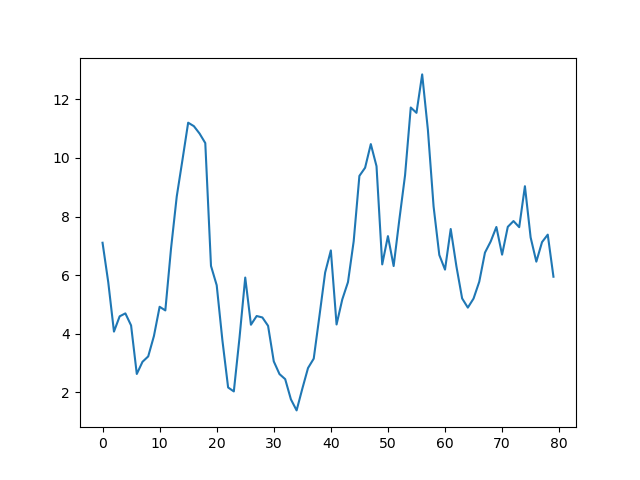

In [14]:
Cseries = C.to_series()
unit = 0
duration = 2
Struct = "CA1"
lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_SWR = pd.Series(np.zeros(duration*2*Acq_freq))
time = range(duration*2*Acq_freq)
Half = int(ActivityCa_S1spin.shape[0]/2)
TimeStamps_miniscope = list(stamps_miniscope["Time Stamp (ms)"])
plt.close()
if Struct == 'S1':
    nb_spindle = S1spiprop.shape[0]
    AVGActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
    print(nb_spindle)
    for unit in range(nb_unit):
        ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in range(nb_spindle):
            ser = pd.Series(S1spiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_S1spin = ActivityCa_S1spin+list(lCseries[index-Half:index+Half])
        nActivityCa_S1spin = ActivityCa_S1spin/max(ActivityCa_S1spin)
        AVGActivityCa_S1spin = AVGActivityCa_S1spin + ActivityCa_S1spin
    plt.plot(time, AVGActivityCa_S1spin)
elif Struct == 'PFC':
    nb_spindle = PFCspiprop.shape[0]
    AVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    for unit in range(nb_unit):
        ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in range(nb_spindle):
            ser = pd.Series(PFCspiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_PFCspin = ActivityCa_PFCspin+list(lCseries[index-Half:index+Half])
        nActivityCa_PFCspin = ActivityCa_PFCspin/max(ActivityCa_PFCspin)
        AVGActivityCa_PFCspin = AVGActivityCa_PFCspin + ActivityCa_PFCspin
    plt.plot(time, AVGActivityCa_PFCspin)

elif Struct == 'CA1':
    nb_swr = SWRprop.shape[0]
    AVGActivityCa_SWR = pd.Series(np.zeros(duration*2*Acq_freq))
    for unit in range(nb_unit):
        ActivityCa_SWR = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in range(nb_swr):
            ser = pd.Series(SWRprop["start time"])
            Frame_SWR_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_SWR_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_SWR = ActivityCa_SWR+list(lCseries[index-Half:index+Half])
        nActivityCa_SWR = ActivityCa_SWR/max(ActivityCa_SWR)
        AVGActivityCa_SWR = AVGActivityCa_SWR + ActivityCa_SWR
    plt.plot(time, AVGActivityCa_SWR)


#plt.close()
#plt.plot(time, ActivityCa_PFCspin)
plt.show()

Same here but with a selection of neurons

In [9]:
Cseries = C.to_series()
unit_to_keep = UnitToKeepInd
duration = 2
Struct = "CA1"
lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_SWR = pd.Series(np.zeros(duration*2*Acq_freq))
time = range(duration*2*Acq_freq)
Half = int(ActivityCa_S1spin.shape[0]/2)
TimeStamps_miniscope = list(stamps_miniscope["Time Stamp (ms)"])
plt.close()
if Struct == 'S1':
    nb_spindle = S1spiprop.shape[0]
    AVGActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
    print(nb_spindle)
    for unit in unit_to_keep:
        ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in range(nb_spindle):
            ser = pd.Series(S1spiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_S1spin = ActivityCa_S1spin+list(lCseries[index-Half:index+Half])
        nActivityCa_S1spin = ActivityCa_S1spin/max(ActivityCa_S1spin)
        AVGActivityCa_S1spin = AVGActivityCa_S1spin + ActivityCa_S1spin
        plt.plot(time, ActivityCa_S1spin)
elif Struct == 'PFC':
    nb_spindle = PFCspiprop.shape[0]
    AVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    for unit in unit_to_keep:
        ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in range(nb_spindle):
            ser = pd.Series(PFCspiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_PFCspin = ActivityCa_PFCspin+list(lCseries[index-Half:index+Half])
        nActivityCa_PFCspin = ActivityCa_PFCspin/max(ActivityCa_PFCspin)
        AVGActivityCa_PFCspin = AVGActivityCa_PFCspin + ActivityCa_PFCspin
        plt.plot(time, ActivityCa_PFCspin)

#plt.close()
#plt.plot(time, ActivityCa_PFCspin)
plt.show()

focusing on the coordinated SWR and spindles

In [176]:
Struct = "PFC"
before = 1550 # ms
after = 000 # ms
counterPFC = 0
counterS1 = 0
Coupled_spindlesPFC = list()
Coupled_spindlesS1 = list()
unCoupled_spindlesPFC = list()
unCoupled_spindlesS1 = list()

nb_spindle = PFCspiprop.shape[0]
print(nb_spindle)
for Pspin in range(nb_spindle):
    ser = pd.Series(PFCspiprop["peak time"])
    serSWR = pd.Series(SWRprop["peak time"])
    Combined_Spindle_SWR = take_closest(serSWR, ser[Pspin])
    distance = Combined_Spindle_SWR - ser[Pspin]
    if (distance > (- before)) and (distance <  after):
        counterPFC = counterPFC + 1
        Coupled_spindlesPFC.append(Pspin)
    else:
        unCoupled_spindlesPFC.append(Pspin)
nb_spindle = S1spiprop.shape[0]
for Pspin in range(nb_spindle-3):
    ser = pd.Series(S1spiprop["start time"])
    serSWR = pd.Series(SWRprop["start time"])
    Combined_Spindle_SWR = take_closest(serSWR, ser[Pspin])
    distance = Combined_Spindle_SWR - ser[Pspin]
    if (distance > (- before)) and (distance <  after):
        counterS1 = counterS1 + 1
        Coupled_spindlesS1.append(Pspin)
    else:
        unCoupled_spindlesS1.append(Pspin)

print(len(Coupled_spindlesPFC))
print(len(unCoupled_spindlesPFC))
print(len(Coupled_spindlesPFC)/(len(Coupled_spindlesPFC)+len(unCoupled_spindlesPFC)))


51
15
36
0.29411764705882354


Same as before but with coupled spindles

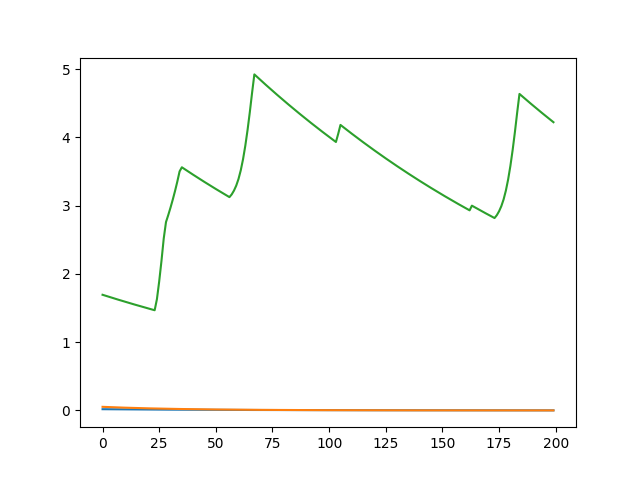

In [174]:
duration = 5
Struct = "PFC"
lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_SWR = pd.Series(np.zeros(duration*2*Acq_freq))
time = range(duration*2*Acq_freq)
Half = int(ActivityCa_S1spin.shape[0]/2)
TimeStamps_miniscope = list(stamps_miniscope["Time Stamp (ms)"])
plt.close()
if Struct == 'S1':
    nb_spindle = S1spiprop.shape[0]
    AVGActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
    print(nb_spindle)
    for unit in range(nb_unit):
        ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in unCoupled_spindlesS1:
            ser = pd.Series(S1spiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_S1spin = ActivityCa_S1spin+list(lCseries[index-Half:index+Half])
        nActivityCa_S1spin = ActivityCa_S1spin/max(ActivityCa_S1spin)
        AVGActivityCa_S1spin = AVGActivityCa_S1spin + ActivityCa_S1spin
        plt.plot(time, ActivityCa_S1spin)
    nAVGActivityCa_S1spin = AVGActivityCa_S1spin/max(AVGActivityCa_S1spin)
elif Struct == 'PFC':
    nb_spindle = PFCspiprop.shape[0]
    AVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    for unit in range(nb_unit):
        ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in Coupled_spindlesPFC:
            ser = pd.Series(PFCspiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_PFCspin = ActivityCa_PFCspin+list(lCseries[index-Half:index+Half])
        nActivityCa_PFCspin = ActivityCa_PFCspin/max(ActivityCa_PFCspin)
        AVGActivityCa_PFCspin = AVGActivityCa_PFCspin + ActivityCa_PFCspin
        plt.plot(time, ActivityCa_PFCspin)
    nAVGActivityCa_PFCspin = AVGActivityCa_PFCspin/max(AVGActivityCa_PFCspin)
#    plt.plot(time, nAVGActivityCa_PFCspin)


#plt.close()
#plt.plot(time, ActivityCa_PFCspin)
plt.show()

In [153]:
UnitToKeepInd

[0, 1, 2, 3]

Coupled spindles + selected units

175.28780436641009 152.0015002180526
35.51240216563521 30.79471743647308
519.5539447212733 671.9752114309135
21.981944444352067 28.430775891001062


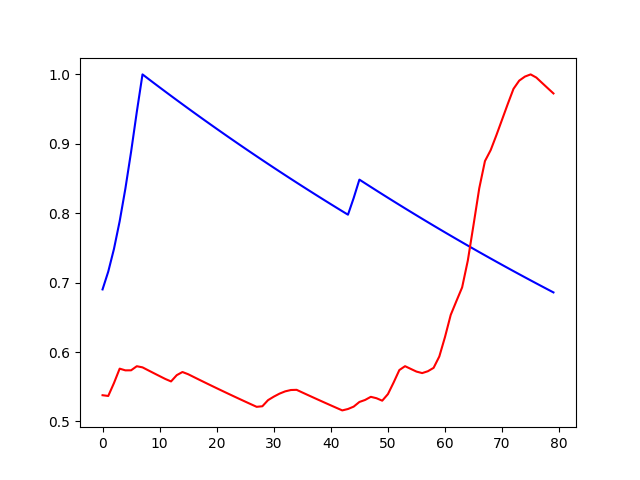

In [175]:
Cseries = C.to_series()
unit_to_keep = UnitToKeepInd
#unit_to_keep = [3, 6]
duration = 2
Struct = "PFC"
lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_SWR = pd.Series(np.zeros(duration*2*Acq_freq))
time = range(duration*2*Acq_freq)
Half = int(ActivityCa_S1spin.shape[0]/2)
TimeStamps_miniscope = list(stamps_miniscope["Time Stamp (ms)"])
plt.close()
if Struct == 'S1':
    AVGActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
    for unit in unit_to_keep:
        ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in Coupled_spindlesS1:
            ser = pd.Series(S1spiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_S1spin = ActivityCa_S1spin+list(lCseries[index-Half:index+Half])
        nActivityCa_S1spin = ActivityCa_S1spin/max(ActivityCa_S1spin)
        AVGActivityCa_S1spin = AVGActivityCa_S1spin + ActivityCa_S1spin
    nAVGActivityCa_S1spin = AVGActivityCa_S1spin/max(AVGActivityCa_S1spin)
    plt.plot(time, nAVGActivityCa_S1spin, color="b")
    AVGActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
    for unit in unit_to_keep:
        ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in unCoupled_spindlesS1:
            ser = pd.Series(S1spiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_S1spin = ActivityCa_S1spin+list(lCseries[index-Half:index+Half])
        nActivityCa_S1spin = ActivityCa_S1spin/max(ActivityCa_S1spin)
        AVGActivityCa_S1spin = AVGActivityCa_S1spin + ActivityCa_S1spin
    nAVGActivityCa_S1spin = AVGActivityCa_S1spin/max(AVGActivityCa_S1spin)
    plt.plot(time, nAVGActivityCa_S1spin, color="r")

elif Struct == 'PFC':
    AVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    for unit in unit_to_keep:
        ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in Coupled_spindlesPFC:
            ser = pd.Series(PFCspiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_PFCspin = ActivityCa_PFCspin+list(lCseries[index-Half:index+Half])
        nActivityCa_PFCspin = ActivityCa_PFCspin/max(ActivityCa_PFCspin)
        AVGActivityCa_PFCspin = AVGActivityCa_PFCspin + ActivityCa_PFCspin    
    nAVGActivityCa_PFCspin = AVGActivityCa_PFCspin/max(AVGActivityCa_PFCspin)
    plt.plot(time, nAVGActivityCa_PFCspin, color="b")  
    CactBefore = sum(AVGActivityCa_PFCspin[0:Half])
    CactAfter = sum(AVGActivityCa_PFCspin[Half:2*Half])
    print(CactBefore, CactAfter)
    nCactBefore = sum(nAVGActivityCa_PFCspin[0:Half])
    nCactAfter = sum(nAVGActivityCa_PFCspin[Half:2*Half])
    print(nCactBefore, nCactAfter) 
    AVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    for unit in unit_to_keep:
        ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in unCoupled_spindlesPFC:
            ser = pd.Series(PFCspiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_PFCspin = ActivityCa_PFCspin+list(lCseries[index-Half:index+Half])
        nActivityCa_PFCspin = ActivityCa_PFCspin/max(ActivityCa_PFCspin)
        AVGActivityCa_PFCspin = AVGActivityCa_PFCspin + ActivityCa_PFCspin
    nAVGActivityCa_PFCspin = AVGActivityCa_PFCspin/max(AVGActivityCa_PFCspin)
    plt.plot(time, nAVGActivityCa_PFCspin, color="r")
    unCactBefore = sum(AVGActivityCa_PFCspin[0:Half])
    unCactAfter = sum(AVGActivityCa_PFCspin[Half:2*Half])
    print(unCactBefore, unCactAfter)
    nunCactBefore = sum(nAVGActivityCa_PFCspin[0:Half])
    nunCactAfter = sum(nAVGActivityCa_PFCspin[Half:2*Half])
    print(nunCactBefore, nunCactAfter)

#plt.close()
#plt.plot(time, ActivityCa_PFCspin)
plt.show()

In [155]:
negCoupledBef = CactBefore
negCoupledAft = CactAfter
negunCoupledBef = unCactBefore
negunCoupledAft = unCactAfter
nnegCoupledBef = nCactBefore
nnegCoupledAft = nCactAfter
nnegunCoupledBef = nunCactBefore
nnegunCoupledAft = nunCactAfter

In [159]:
posCoupledBef = CactBefore
posCoupledAft = CactAfter
posunCoupledBef = unCactBefore
posunCoupledAft = unCactAfter
nposCoupledBef = nCactBefore
nposCoupledAft = nCactAfter
nposunCoupledBef = nunCactBefore
nposunCoupledAft = nunCactAfter

In [160]:
outSumm = pd.Series([negCoupledBef, negCoupledAft, negunCoupledBef, negunCoupledAft, nnegCoupledBef, nnegCoupledAft, nnegunCoupledBef, nnegunCoupledAft, posCoupledBef, posCoupledAft, posunCoupledBef, posunCoupledAft, nposCoupledBef, nposCoupledAft, nposunCoupledBef, nposunCoupledAft],
              index=["NCB", "NCA", "N1CB", "N1CA", "nNCB", "nNCA", "nN1CB", "nN1CB", "PCB", "PCA", "P1CB", "P1CA", "nPCB", "nPC1", "nP1CB", "nP1CA"])


filenameOut = folder_base / f'Ca2+intSWRspindles.xlsx'
writer = pd.ExcelWriter(filenameOut)
outSumm.to_excel(writer)
writer.save()